### Install Required Packages

In [ ]:
!pip install daam==0.0.11
!pip install accelerate  # this is to reduce CPU model load overhead
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 453 kB 41.1 MB/s 
     |████████████████████████████████| 13.8 MB 69.4 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 5.5 MB 65.8 MB/s 
     |████████████████████████████████| 182 kB 79.8 MB/s 
     |████████████████████████████████| 7.6 MB 68.3 MB/s 
     |████████████████████████████████| 56 kB 5.5 MB/s 
     |████████████████████████████████| 55 kB 4.5 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 278 kB 84.5 MB/s 
     |████████████████████████████████| 106 kB 82.1 MB/s 
     |████████████████████████████████| 2.3 MB 68.5 MB/s 
     |████████████████████████████████| 84 kB 4.6 MB/s 
     |████████████████████████████████| 64 kB 3.6 MB/s 
     |████████████████████████████████| 80 kB 11.2 MB/s 
     |████████████████████████████████| 69 

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-511ad1dd-855d-9ef1-fbca-2251339f17a5)


### Load Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [ ]:
import os
import json
import datetime
from tqdm import tqdm
import base64
import IPython
import random
import requests
from io import BytesIO
from math import trunc

from matplotlib import pyplot as plt
import numpy as np

from PIL import Image
from PIL import ImageDraw as PILImageDraw
import cv2

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag 

from diffusers import StableDiffusionPipeline
import daam
import torch

from pycocotools.coco import COCO

Download the stopwords for removing stopwords

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### Load Data

The below list is a placeholder for any list of prompts, we will be replacing it with a list of prompts from `MS-COCO` text annotations later.

In [ ]:
prompts = [
  "A group of people stand in the back of a truck filled with cotton.",
  "A mother and three children collecting garbage from a blue and white garbage can on the street.",
  "A woman is sitting in a chair reading a book with her head resting on her free hand.",
  "A brown and white dog exiting a yellow and blue ramp in a grassy area.",
  "A boy stands on a rocky mountain."
  ]

# prompts = [
#   "A group of people stand in the back of a truck filled with cotton."
# ]

### Prompt Processing

Cleaning the prompts. I adopt few ways to clean the prompt:
- Tokenization
- Lemmatization
- Remove stop words
- Remove non-alphabets
- Keep only nouns (gives bad result, due to NLTK's pos tagger not in use right now)

In [ ]:
# Stopwords
stpwords = set(stopwords.words('english'))

# Lemmatizer
lemmatizer = WordNetLemmatizer() 

def clean_prompt(prompt):
  # tokenize each prompt after they have been converted into lower case
  prompt_tokenized = nltk.word_tokenize(prompt.lower())
  # lemmatize above prompt
  lemmatized_prompt = [lemmatizer.lemmatize(word) for word in prompt_tokenized]

  # pos tag lemmatized prompt above
  # pos_tagged_prompt = pos_tag(lemmatized_prompt)

  # keep only the noun words
  fin_prompt = [word for word in lemmatized_prompt if (word not in stpwords and word.isalpha())]
  return fin_prompt

### Setting up the Pipeline

#### Brief Overview of the Storage Scheme of the Generated Data

I will set up the pipeline for generation of the heatmaps and bounding boxes for each generated image for each prompt in the `prompts` list. We will be generating `NUM_IMAGES_PER_PROMPT` images per prompt.

Every output by our code will be stored in `Data-Generated` folder.

I use `COCO` Dataset format to store the bboxes and segmentation for each image.

#### Set some parameters

In [ ]:
NUM_IMAGES_PER_PROMPT = 2 # Number of images to be generated per prompt
NUM_INFERENCE_STEPS = 50 # Number of inference steps to the Diffusion Model
NAME_OF_DATASET = 'COCO Stable Diffusion 2 Dataset' # Name of the generated dataset
SAVE_AFTER_NUM_IMAGES = 3 # Number of images after which the annotation and caption files will be saved

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [ ]:
model = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to('cuda')

Downloading:   0%|          | 0.00/539 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/308 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/738 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/460 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/716 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Setting up the folder structure to generate the data and the dataset information for storing annotations and captions in `COCO` format.

In [ ]:
# The folder that will contain the generated data
os.mkdir('Data-Generated') # Stores everything that is generated
os.mkdir('Data-Generated/images') # Stores generated images
os.mkdir('Data-Generated/annotations') # Stores Annotations
os.mkdir('Data-Generated/captions') # Stores Captions

info = { # Info about the dataset
    "description": NAME_OF_DATASET,
    "url": "https://github.com/RishiDarkDevil/Text-Based-Object-Discovery",
    "version": "1.0",
    "year": 2022,
    "contributor": "Rishi Dey Chowdhury (RishiDarkDevil)",
    "date_created": "2022"
}

licenses = [{ # Licenses associated with the dataset
    'url': 'https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL',
    'id': 1,
    'name': 'CreativeML Open RAIL++-M License'
}]

images = list() # Stores the generated image info
annotations = list() # Stores the annotation info
categories = list() # Stores the category info
captions = list() # Stores the captions info
cat2id = dict() # Stores the category to id mapping
cat_id = 1 # Assigns id to categories as we go on adding categories which we discover
image_id = 1 # Assigns generated image ids
annotation_id = 1 # Assigns annotations annotation ids
caption_id = 1 # Assigns captions caption ids
save_idx = 1 # The index which stores how many times we saved the json file before

Let's generate Global Word Attribution HeatMaps.

In [ ]:
class NpEncoder(json.JSONEncoder): # To help encode the unsupported datatypes to json serializable format
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return json.JSONEncoder.default(self, obj)

def save(): # Saving annotations and captions when called -- mainly to avoid code repetition
  # Serializing json
  json_obj_det = json.dumps({
      'info': info,
      'licenses': licenses,
      'images': images,
      'annotations': annotations,
      'categories': categories
  }, indent=4, cls=NpEncoder)

  # Writing json
  with open(f"Data-Generated/annotations/object_detect-{save_idx}.json", "w") as outfile:
    outfile.write(json_obj_det)

  print('Saved Annotations')

  # Delete json from python env
  del json_obj_det

  # Serializing json
  json_obj_cap = json.dumps({
      'info': info,
      'licenses': licenses,
      'images': images,
      'annotations': captions,
  }, indent=4, cls=NpEncoder)

  # Writing json
  with open(f"Data-Generated/captions/object_caption-{save_idx}.json", "w") as outfile:
    outfile.write(json_obj_cap)

  # Delete json from python env
  del json_obj_cap

  # Clearing out all the lists except cat2id to maintaining the unique category ids assigned to each new object
  images.clear()
  annotations.clear()
  categories.clear()
  captions.clear()

In [ ]:
try:
  # Iterating overs the prompts
  for i, prompt in enumerate(prompts):

    # Flashing some details
    print(f'Prompt No. {i+1}/{len(prompts)}')
    print('Prompt:', prompt)
    cleaned_prompt = clean_prompt(prompt)
    print('Cleaned Prompt:', ' '.join(cleaned_prompt))
    print('Generating Image...')

    # Updating Categories using cleaned prompt if required and assigning index
    for word in cleaned_prompt:
      if word not in cat2id:
        print(cat2id)
        print(word)
        cat2id[word] = cat_id
        categories.append({"supercategory": '', "id": cat_id, "name": word}) ### FIX SUPERCATEGORY
        cat_id += 1

    for j in range(NUM_IMAGES_PER_PROMPT):

      # Generating images and storing their trace for daam output
      with daam.trace(model) as trc:
        output_image = model(prompt, num_inference_steps=NUM_INFERENCE_STEPS).images[0]
        global_heat_map = trc.compute_global_heat_map()

      # Saving generated Image
      output_image.save(f'Data-Generated/images/{i}_{j}.png')
      print(f'Saving generated Image as.. {i}_{j}.png')

      width, height = output_image.size
      # Image details
      image_det = {
          'license': 1,
          'file_name': f'{i}_{j}.png',
          'height': height,
          'width': width,
          'date_captured': datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S"),
          'id': image_id
      }
      images.append(image_det)

      # Captions details
      cap_det = {
          'id': caption_id,
          'image_id': image_id,
          'caption': prompt
      }
      captions.append(cap_det)

      print(f'Generating Annotations for {i}_{j}.png')
      # Generate Global Word Attribution HeatMap
      for word in tqdm(cleaned_prompt):

        # word category id
        word_cat_id = cat2id[word]
        
        # Compute heatmap for a non-stopword
        word_heatmap = global_heat_map.compute_word_heat_map(word).expand_as(output_image).numpy()

        # Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
        heatmap = np.array(word_heatmap * 255, dtype = np.uint8)

        # Binary threshold of the above heatmap - serves as sort of semantic segmentation for the word
        thresh = cv2.threshold(heatmap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # Find contours from the binary threshold
        cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]

        # Annotating the segmentation and the bounding boxes
        for idx, cnt in enumerate(cnts):
          x,y,w,h = cv2.boundingRect(cnt)
          area = cv2.contourArea(cnt)

          ann_det = { # Annotation details
              'segmentation': [list(cnt.squeeze().reshape(1, -1).squeeze())],
              'area': area,
              'iscrowd': 0,
              'image_id': image_id,
              'bbox': [x, y, w, h],
              'category_id': word_cat_id,
              'id': annotation_id,
          }
          annotation_id += 1
          annotations.append(ann_det)
      
      print()
      print('Generated Annotations...')
      
      # Saving Annotations and Captions
      if image_id % SAVE_AFTER_NUM_IMAGES == 0:
        save()
        print(f'Annotations and Captions saved... object_detect-{save_idx}.json and object_caption-{save_idx}.json')

        save_idx += 1

      image_id += 1

      caption_id += 1

  if ((image_id-1) % SAVE_AFTER_NUM_IMAGES != 0 and image_id > 1) or image_id == 1:
    save()

except KeyboardInterrupt: # In case of KeyboardInterrupt save the annotations and captions
  save()

Prompt No. 1/5
Prompt: A group of people stand in the back of a truck filled with cotton.
Cleaned Prompt: group people back truck filled cotton
Generating Image...
{}
group
{'group': 1}
people
{'group': 1, 'people': 2}
back
{'group': 1, 'people': 2, 'back': 3}
truck
{'group': 1, 'people': 2, 'back': 3, 'truck': 4}
filled
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5}
cotton


  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 0_0.png
Generating Annotations for 0_0.png


100%|██████████| 6/6 [00:00<00:00, 247.08it/s]


Generated Annotations...


  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 0_1.png
Generating Annotations for 0_1.png


100%|██████████| 6/6 [00:00<00:00, 255.25it/s]


Generated Annotations...
Prompt No. 2/5
Prompt: A mother and three children collecting garbage from a blue and white garbage can on the street.
Cleaned Prompt: mother child garbage blue garbage street
Generating Image...
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6}
mother
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7}
child
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7, 'child': 8}
garbage
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7, 'child': 8, 'garbage': 9}
blue
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7, 'child': 8, 'garbage': 9, 'blue': 10}
street


  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 1_0.png
Generating Annotations for 1_0.png


100%|██████████| 6/6 [00:00<00:00, 140.38it/s]


Generated Annotations...


Saved Annotations
Annotations and Captions saved... object_detect-1.json and object_caption-1.json


  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 1_1.png
Generating Annotations for 1_1.png


100%|██████████| 6/6 [00:00<00:00, 242.95it/s]


Generated Annotations...
Prompt No. 3/5
Prompt: A woman is sitting in a chair reading a book with her head resting on her free hand.
Cleaned Prompt: woman chair book head hand
Generating Image...
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7, 'child': 8, 'garbage': 9, 'blue': 10, 'street': 11}
woman
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7, 'child': 8, 'garbage': 9, 'blue': 10, 'street': 11, 'woman': 12}
chair
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7, 'child': 8, 'garbage': 9, 'blue': 10, 'street': 11, 'woman': 12, 'chair': 13}
book
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7, 'child': 8, 'garbage': 9, 'blue': 10, 'street': 11, 'woman': 12, 'chair': 13, 'book': 14}
head
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7, 'child': 8, 'garbage': 9, 'blue': 10, 'street': 11, 'wom

  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 2_0.png
Generating Annotations for 2_0.png


100%|██████████| 5/5 [00:00<00:00, 197.25it/s]


Generated Annotations...


  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 2_1.png
Generating Annotations for 2_1.png


100%|██████████| 5/5 [00:00<00:00, 214.72it/s]


Generated Annotations...
Saved Annotations
Annotations and Captions saved... object_detect-2.json and object_caption-2.json
Prompt No. 4/5
Prompt: A brown and white dog exiting a yellow and blue ramp in a grassy area.
Cleaned Prompt: brown dog yellow ramp area
Generating Image...
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7, 'child': 8, 'garbage': 9, 'blue': 10, 'street': 11, 'woman': 12, 'chair': 13, 'book': 14, 'head': 15, 'hand': 16}
brown
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7, 'child': 8, 'garbage': 9, 'blue': 10, 'street': 11, 'woman': 12, 'chair': 13, 'book': 14, 'head': 15, 'hand': 16, 'brown': 17}
dog
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7, 'child': 8, 'garbage': 9, 'blue': 10, 'street': 11, 'woman': 12, 'chair': 13, 'book': 14, 'head': 15, 'hand': 16, 'brown': 17, 'dog': 18}
yellow
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled':

  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 3_0.png
Generating Annotations for 3_0.png


100%|██████████| 5/5 [00:00<00:00, 277.20it/s]


Generated Annotations...


  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 3_1.png
Generating Annotations for 3_1.png


100%|██████████| 5/5 [00:00<00:00, 257.76it/s]


Generated Annotations...
Prompt No. 5/5
Prompt: A boy stands on a rocky mountain.
Cleaned Prompt: stand mountain
Generating Image...
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7, 'child': 8, 'garbage': 9, 'blue': 10, 'street': 11, 'woman': 12, 'chair': 13, 'book': 14, 'head': 15, 'hand': 16, 'brown': 17, 'dog': 18, 'yellow': 19, 'ramp': 20, 'area': 21}
stand
{'group': 1, 'people': 2, 'back': 3, 'truck': 4, 'filled': 5, 'cotton': 6, 'mother': 7, 'child': 8, 'garbage': 9, 'blue': 10, 'street': 11, 'woman': 12, 'chair': 13, 'book': 14, 'head': 15, 'hand': 16, 'brown': 17, 'dog': 18, 'yellow': 19, 'ramp': 20, 'area': 21, 'stand': 22}
mountain


  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 4_0.png
Generating Annotations for 4_0.png


100%|██████████| 2/2 [00:00<00:00, 247.20it/s]


Generated Annotations...
Saved Annotations
Annotations and Captions saved... object_detect-3.json and object_caption-3.json


  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 4_1.png
Generating Annotations for 4_1.png


100%|██████████| 2/2 [00:00<00:00, 261.10it/s]


Generated Annotations...
Saved Annotations


In case we generate multiple annotation files we will have to merge them together into a single json file. The following cell does just that and results into a single `annotations.json`.

In [ ]:
print('Starting Annotation Files Merge...')
# Annotation File Names present in the annotations directory
ann_file_names = os.listdir('Data-Generated/annotations')
print('Number of Annotation Files found:', len(ann_file_names))
print('Annotation Files found:', ' '.join(ann_file_names))
ann_files = list() # Contains the list of loaded annotation json files
for ann_file_name in tqdm(ann_file_names): # Loads the annotation json files and appens to ann_files
  with open(os.path.join('Data-Generated/annotations', ann_file_name)) as json_file:
    ann_file = json.load(json_file)
    ann_files.append(ann_file)
# Creating the single annotation file
annotation_file = {
    'info': ann_files[0]['info'],
    'licenses': ann_files[0]['licenses'],
    'images': [image for ann_file in ann_files for image in ann_file['images']],
    'annotations': [ann for ann_file in ann_files for ann in ann_file['annotations']],
    'categories': [cat for ann_file in ann_files for cat in ann_file['categories']]
}
# Serializing json
ann_json_file = json.dumps(annotation_file, indent=4)
# Writing json
with open(f"Data-Generated/annotations/annotations.json", "w") as outfile:
  outfile.write(ann_json_file)
print()
print('Saved Annotation file... annotations.json')
# UNCOMMENT IF YOU WISH TO REMOVE ALL THE ANNOTATION FILES EXCEPT ONE BIG ANNOTATION FILE
# print('Removing the annotation files other than annotations.json')
# for ann_file_name in ann_file_names:
#   os.remove(os.path.join('Data-Generated/annotations', ann_file_name))
print('A successful merge!')

Starting Annotation Files Merge...
Number of Annotation Files found: 4
Annotation Files found: object_detect-4.json object_detect-1.json object_detect-3.json object_detect-2.json


100%|██████████| 4/4 [00:00<00:00, 193.82it/s]


Saved Annotation file... annotations.json
Removing the annotation files other than annotations.json
A successful merge!


In case we generate multiple caption files we will have to merge them together into a single json file. The following cell does just that and results into a single `captions.json`.

In [ ]:
print('Starting Caption Files Merge...')
# Caption File Names present in the captions directory
cap_file_names = os.listdir('Data-Generated/captions')
print('Number of Caption Files found:', len(cap_file_names))
print('Caption Files found:', ' '.join(cap_file_names))
cap_files = list() # Contains the list of loaded caption json files
for cap_file_name in tqdm(cap_file_names): # Loads the caption json files and appens to cap_files
  with open(os.path.join('Data-Generated/captions', cap_file_name)) as json_file:
    cap_file = json.load(json_file)
    cap_files.append(cap_file)
# Creating the single caption file
caption_file = {
    'info': cap_files[0]['info'],
    'licenses': cap_files[0]['licenses'],
    'images': [image for cap_file in cap_files for image in cap_file['images']],
    'annotations': [ann for cap_file in cap_files for ann in cap_file['annotations']],
}
# Serializing json
cap_json_file = json.dumps(caption_file, indent=4)
# Writing json
with open(f"Data-Generated/captions/captions.json", "w") as outfile:
  outfile.write(cap_json_file)
print()
print('Saved Caption file... captions.json')
# UNCOMMENT IF YOU WISH TO REMOVE ALL THE CAPTION FILES EXCEPT ONE BIG CAPTION FILE
# print('Removing the caption files other than captions.json')
# for cap_file_name in cap_file_names:
#   os.remove(os.path.join('Data-Generated/captions', cap_file_name))
print('A successful merge!')

Starting Caption Files Merge...
Number of Caption Files found: 4
Caption Files found: object_caption-1.json object_caption-2.json object_caption-4.json object_caption-3.json


100%|██████████| 4/4 [00:00<00:00, 7560.71it/s]


Saved Caption file... captions.json
Removing the caption files other than captions.json
A successful merge!


To download the folder containing all the generated data.

In [ ]:
# UNCOMMENT DOWNLOAD THE GENERATED DATA FOLDER
# !zip -r /content/file.zip /content/Data-Generated
# from google.colab import files
# files.download("/content/file.zip")

updating: content/Data-Generated/ (stored 0%)
updating: content/Data-Generated/annotations/ (stored 0%)
updating: content/Data-Generated/annotations/annotations.json (deflated 93%)
updating: content/Data-Generated/captions/ (stored 0%)
updating: content/Data-Generated/captions/captions.json (deflated 82%)
updating: content/Data-Generated/images/ (stored 0%)
updating: content/Data-Generated/images/1_0.png (deflated 0%)
updating: content/Data-Generated/images/3_0.png (deflated 0%)
updating: content/Data-Generated/images/4_0.png (deflated 0%)
updating: content/Data-Generated/images/3_1.png (deflated 0%)
updating: content/Data-Generated/images/2_1.png (deflated 0%)
updating: content/Data-Generated/images/2_0.png (deflated 0%)
updating: content/Data-Generated/images/4_1.png (deflated 0%)
updating: content/Data-Generated/images/0_1.png (deflated 0%)
updating: content/Data-Generated/images/1_1.png (deflated 0%)
updating: content/Data-Generated/images/0_0.png (deflated 0%)
  adding: content/Da

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

If in case you need to delete the `Data-Generated` folder with all its contents.

In [ ]:
# # UNCOMMENT IF NEEDED
# import shutil
# shutil.rmtree('Data-Generated')

### Visualizing DAAM Annotated Images

Now that I have generated the images for the prompts and annotated each image with the segmentations and bounding boxes. Let's visualize stuffs.

In [ ]:
# from directory_tree import display_tree
# display_tree('Data-Generated')


$ Operating System : Linux
$ Path : Data-Generated

*************** Directory Tree ***************

Data-Generated/
├── annotations/
│   └── object_detect-1.json
├── captions/
│   └── object_caption-1.json
└── images/
    ├── 0_0.png
    ├── 0_1.png
    ├── 1_0.png
    ├── 1_1.png
    ├── 2_0.png
    ├── 2_1.png
    ├── 3_0.png
    ├── 3_1.png
    ├── 4_0.png
    └── 4_1.png


Set the `annotation_path` and `image_dir` below.

In [ ]:
annotation_path = r'Data-Generated/annotations/annotations.json'
image_dir = r'Data-Generated/images'

In [ ]:
coco_annotation = COCO(annotation_file=annotation_path)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


Below we visualize our synthetic annotated dataset.

In [ ]:
def visualize_annotation(image_id, figsize = (20,10)):
  # Load Image Details corresponding to the image_id
  img_info = coco_annotation.loadImgs([image_id])[0]
  img_file_name = img_info['file_name']
  # Load Annotation Details corresponding to the image_id
  ann_ids = coco_annotation.getAnnIds(imgIds=[image_id], iscrowd=None)
  anns = coco_annotation.loadAnns(ann_ids)
  # Load Image corresponding to the image_id
  im = Image.open(os.path.join(image_dir, img_file_name))
  # Plot and visualize results
  fig, ax = plt.subplots(1, 2, figsize=figsize)
  ax[0].axis('off')
  ax[1].axis('off')
  ax[0].imshow(np.asarray(im))
  ax[1].imshow(np.asarray(im))
  coco_annotation.showAnns(anns, draw_bbox=True)
  ann_names = [coco_annotation.loadCats(ann['category_id'])[0]['name'] for ann in anns]
  for i, ann in enumerate(anns):
    ax[1].text(anns[i]['bbox'][0], anns[i]['bbox'][1], ann_names[i], style='italic', 
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
  

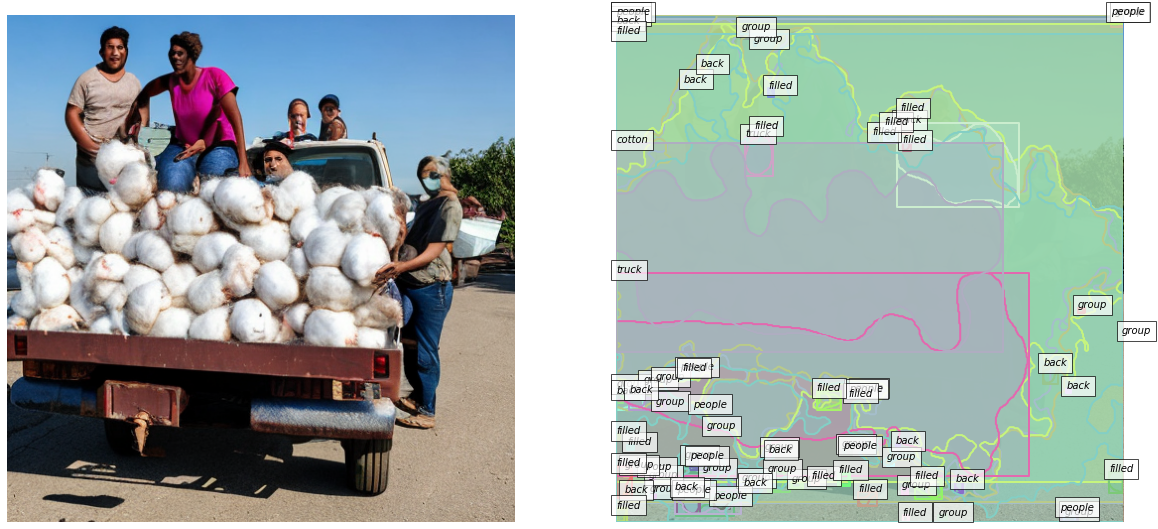

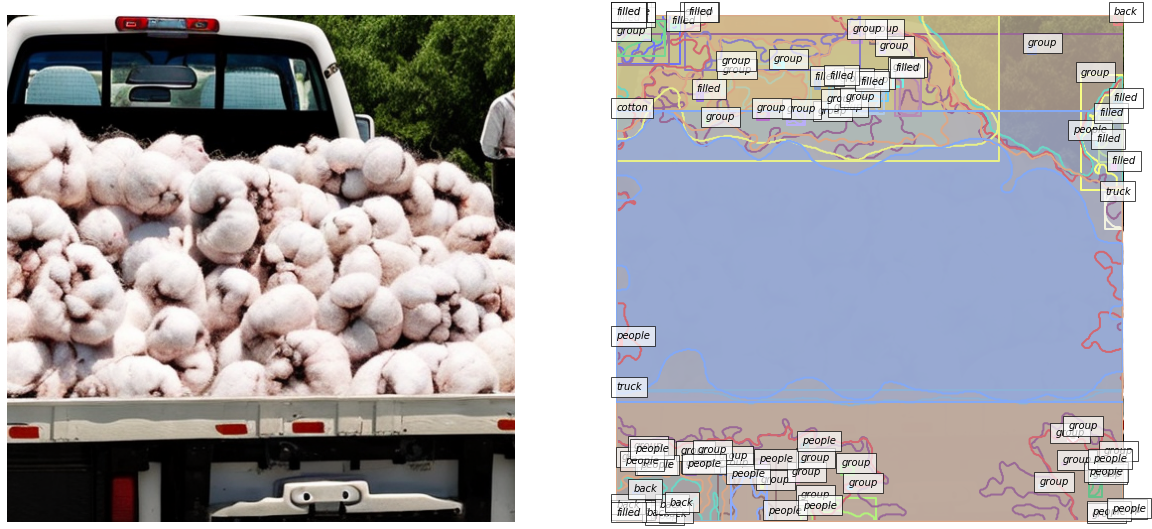

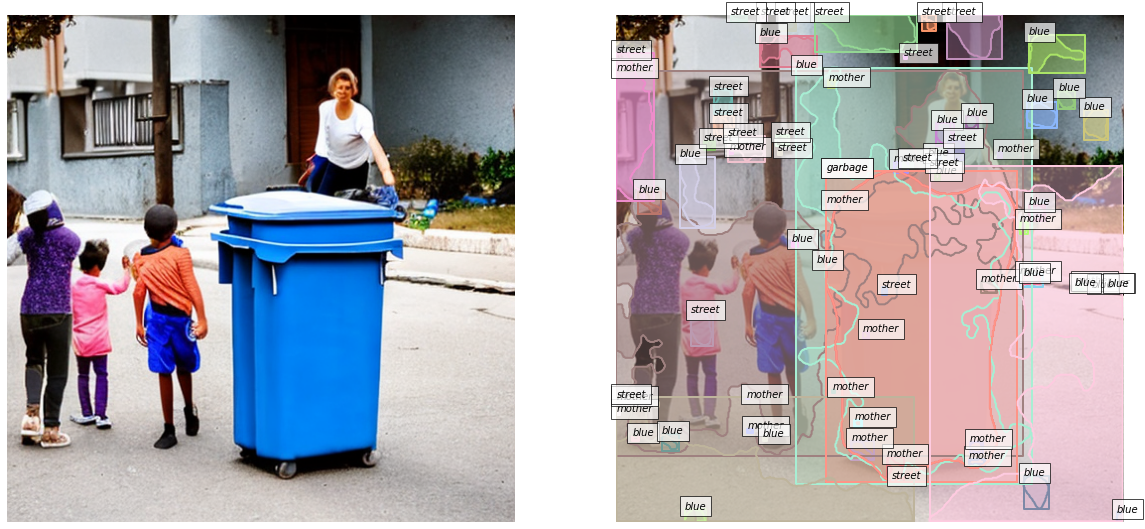

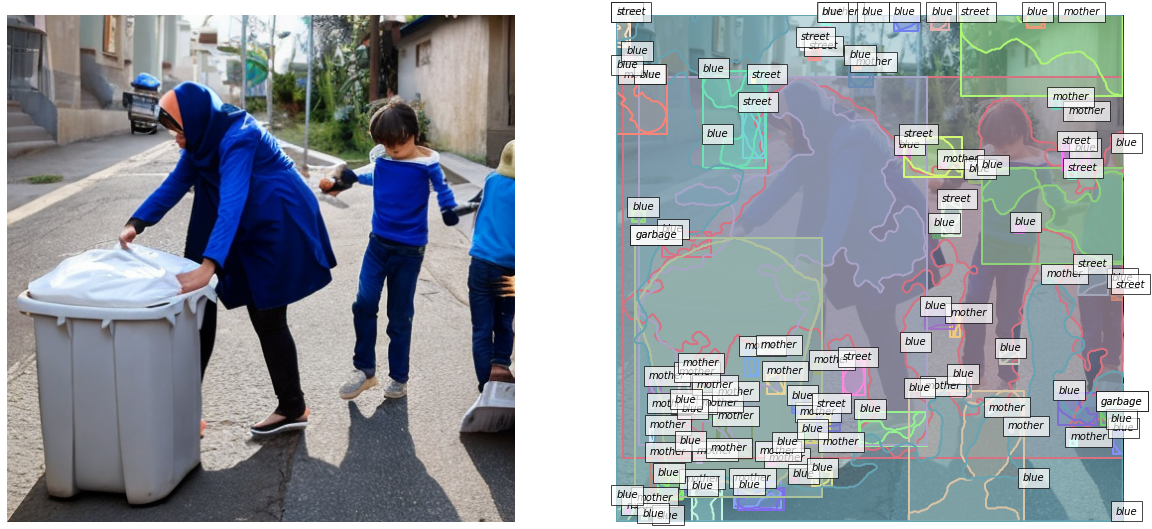

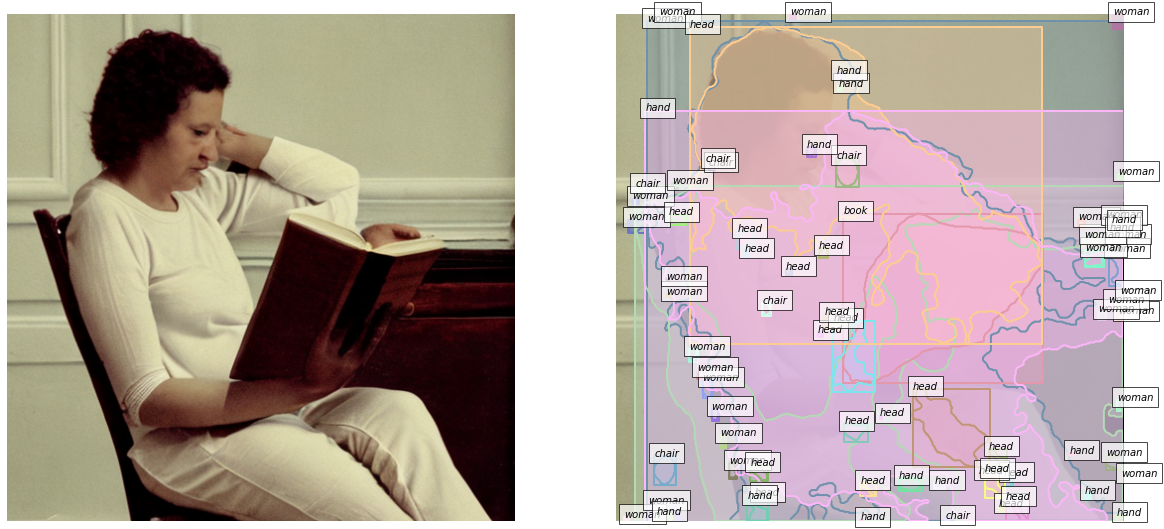

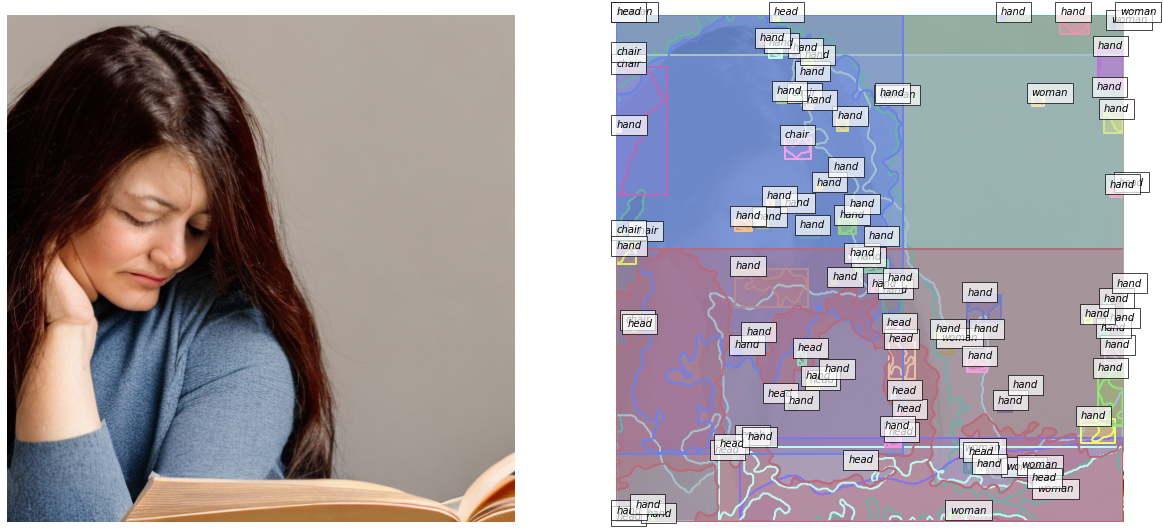

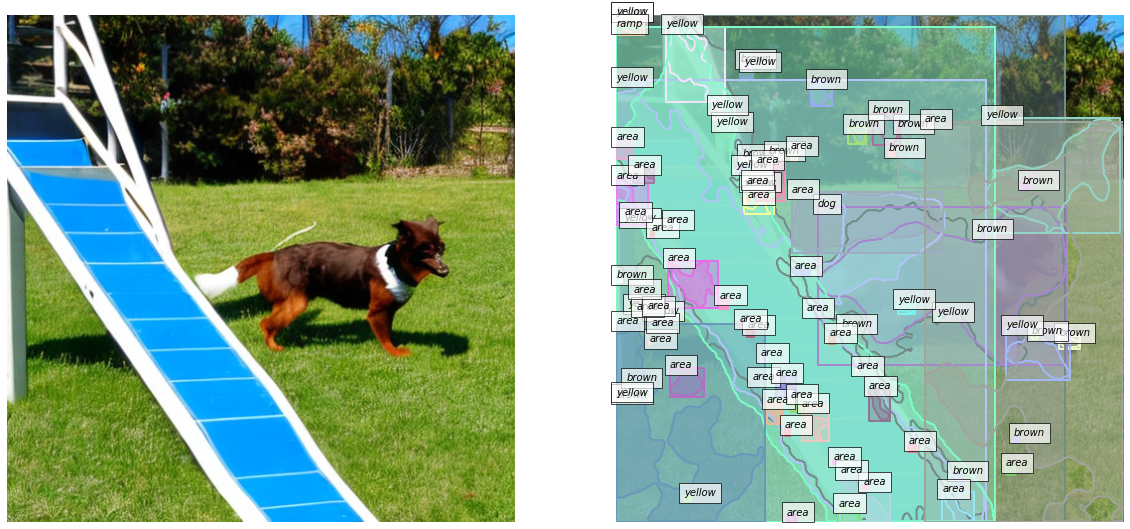

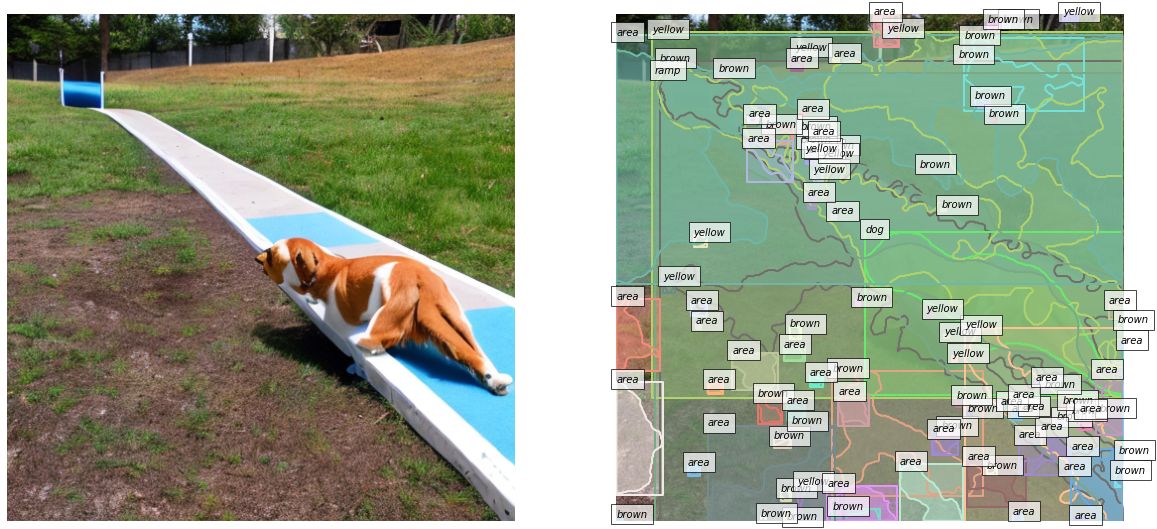

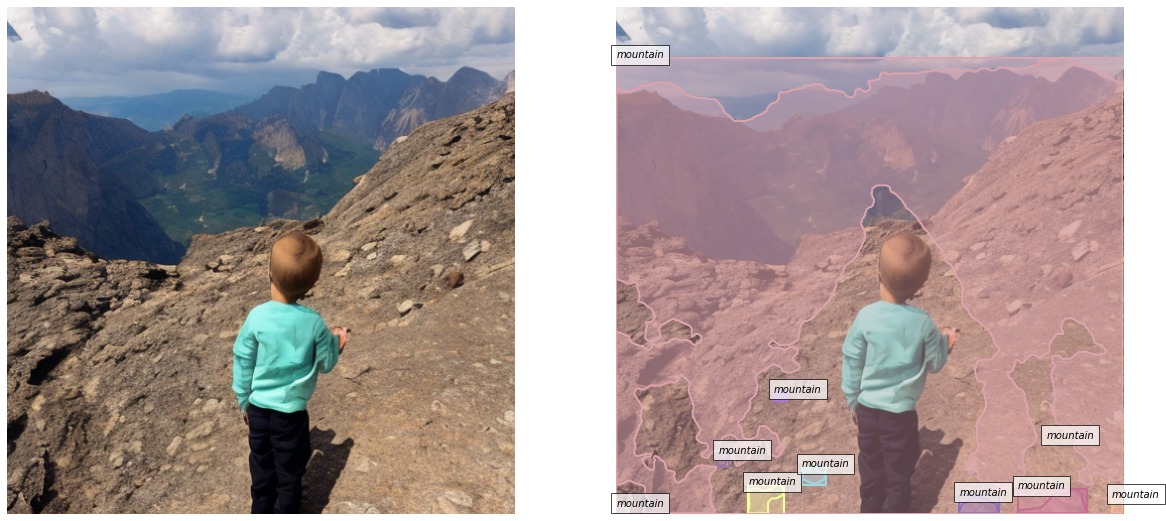

In [ ]:
for i in range(1, 5):
  visualize_annotation(i)